##Data collection

In [2]:
!pip install keras-tuner --upgrade #install keras tuner
!pip install tensorflow-addons




   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 7.6 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.1
    Uninstalling typeguard-4.4.1:
      Successfully uninstalled typeguard-4.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.4.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [33]:
# General libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from scipy.stats import mstats
from scipy.stats.mstats import winsorize

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, AUC, Accuracy
from keras_tuner import RandomSearch  # Correct import for Keras Tuner
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
# Scikit-learn and imbalanced-learn
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.feature_selection import RFE
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

from sklearn.metrics import roc_curve, auc



In [ ]:
df = pd.read_csv('/content/drive/MyDrive/final_nhanes_data/final_merged_data.csv')

df.drop(['Diabetes_Status_x', 'Diabetes_Status_y'], axis=1, inplace=True)
df.head()

,SEQN,FastingStatus,Fasting_Glucose_mg_dL,Insulin_Units,Glycohemoglobin (%),Direct HDL-Cholesterol (mg/dL),Total_Cholesterol_mg_dL,Gender,AgeYears,FamilyIncomeRatio,...,Cholesterol (mg),Sodium (mg),BMI,Weight,Height,Waist,Avg_Systolic_BP,Avg_Diastolic_BP,Smoking status,Drinking_frequency
0,109271.0,1,103.0,16.96,5.6,33.0,147.0,1,49,NaN,...,269.0,5446.0,29.7,98.8,182.3,120.4,107.000000,67.000000,1.0,0.0
1,109274.0,1,154.0,13.52,5.7,29.0,105.0,1,68,1.20,...,300.0,6717.0,30.2,103.7,185.3,109.6,134.000000,70.000000,0.0,7.0
2,109282.0,1,95.0,7.49,5.5,43.0,233.0,1,76,3.61,...,211.0,2456.0,26.6,83.3,177.1,NaN,139.333333,72.666667,1.0,0.0
3,109286.0,0,92.0,16.46,5.7,67.0,236.0,2,33,1.36,...,901.0,7251.0,28.9,72.6,158.4,NaN,119.806263,71.599455,0.0,NaN
4,109290.0,1,106.0,20.25,8.4,40.0,165.0,2,68,5.00,...,46.0,1059.0,28.1,73.0,161.2,92.0,121.333333,60.333333,0.0,0.0


In [ ]:
#concat diabetes status
d_17 = pd.read_csv('/content/processedDiabetes_data17-20 (1).csv')
d_18 = pd.read_csv('/content/processedDiabetes_data17-20 (1).csv')
df_diabetes = pd.concat([d_17, d_18])
df_diabetes.head()

,SEQN,Diabetes_Status
0,109263,2
1,109264,2
2,109265,2
3,109266,2
4,109267,2


In [ ]:
#merge diabetes status with lab and lifestyle df
merged_df = pd.merge(df_diabetes, df, on='SEQN', how='inner')


merged_df.head()

,SEQN,Diabetes_Status,FastingStatus,Fasting_Glucose_mg_dL,Insulin_Units,Glycohemoglobin (%),Direct HDL-Cholesterol (mg/dL),Total_Cholesterol_mg_dL,Gender,AgeYears,...,Cholesterol (mg),Sodium (mg),BMI,Weight,Height,Waist,Avg_Systolic_BP,Avg_Diastolic_BP,Smoking status,Drinking_frequency
0,109271,2,1,103.0,16.96,5.6,33.0,147.0,1,49,...,269.0,5446.0,29.7,98.8,182.3,120.4,107.000000,67.000000,1.0,0.0
1,109274,1,1,154.0,13.52,5.7,29.0,105.0,1,68,...,300.0,6717.0,30.2,103.7,185.3,109.6,134.000000,70.000000,0.0,7.0
2,109282,2,1,95.0,7.49,5.5,43.0,233.0,1,76,...,211.0,2456.0,26.6,83.3,177.1,NaN,139.333333,72.666667,1.0,0.0
3,109286,2,0,92.0,16.46,5.7,67.0,236.0,2,33,...,901.0,7251.0,28.9,72.6,158.4,NaN,119.806263,71.599455,0.0,NaN
4,109290,1,1,106.0,20.25,8.4,40.0,165.0,2,68,...,46.0,1059.0,28.1,73.0,161.2,92.0,121.333333,60.333333,0.0,0.0


##EDA

In [ ]:
# rows and columns in data
merged_df.shape

(8872, 26)

In [ ]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8872 entries, 0 to 8871
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   SEQN                            8872 non-null   int64  
 1   Diabetes_Status                 8872 non-null   int64  
 2   FastingStatus                   8872 non-null   int64  
 3   Fasting_Glucose_mg_dL           8342 non-null   float64
 4   Insulin_Units                   8154 non-null   float64
 5   Glycohemoglobin (%)             8404 non-null   float64
 6   Direct HDL-Cholesterol (mg/dL)  8218 non-null   float64
 7   Total_Cholesterol_mg_dL         8218 non-null   float64
 8   Gender                          8872 non-null   int64  
 9   AgeYears                        8872 non-null   int64  
 10  FamilyIncomeRatio               7614 non-null   float64
 11  Energy (kcal)                   8054 non-null   float64
 12  Protein (gm)                    80

In [ ]:
merged_df.describe()

,SEQN,Diabetes_Status,FastingStatus,Fasting_Glucose_mg_dL,Insulin_Units,Glycohemoglobin (%),Direct HDL-Cholesterol (mg/dL),Total_Cholesterol_mg_dL,Gender,AgeYears,...,Cholesterol (mg),Sodium (mg),BMI,Weight,Height,Waist,Avg_Systolic_BP,Avg_Diastolic_BP,Smoking status,Drinking_frequency
count,8872.000000,8872.000000,8872.000000,8342.000000,8154.000000,8404.000000,8218.000000,8218.000000,8872.000000,8872.000000,...,8054.000000,8054.000000,8692.000000,8716.00000,8706.000000,8398.000000,8872.000000,8872.000000,8866.000000,7514.000000
mean,117185.454689,1.872858,0.897205,112.921362,15.033988,5.851571,53.812606,182.860793,1.518034,49.640667,...,313.767817,3422.768562,29.812011,83.20413,166.817551,100.173446,123.425061,73.983555,0.412362,3.677935
std,4497.972881,0.411286,0.303708,37.530719,23.967576,1.136632,15.934068,41.072818,0.499703,18.287298,...,252.451568,1866.275497,7.721695,23.34919,10.022065,17.473694,18.292409,11.009480,0.492287,3.075963
min,109271.000000,1.000000,0.000000,47.000000,0.710000,2.800000,11.000000,76.000000,1.000000,18.000000,...,0.000000,2.000000,14.900000,36.70000,131.100000,61.100000,78.666667,41.333333,0.000000,0.000000
25%,113330.250000,2.000000,1.000000,95.000000,6.170000,5.300000,42.000000,154.000000,1.000000,34.000000,...,134.000000,2160.000000,24.600000,66.90000,159.300000,87.500000,111.333333,67.000000,0.000000,1.000000
50%,117247.000000,2.000000,1.000000,103.000000,10.010000,5.600000,51.000000,179.000000,2.000000,51.000000,...,241.000000,3091.000000,28.500000,79.80000,166.500000,98.700000,119.806263,71.666667,0.000000,3.000000
75%,121077.250000,2.000000,1.000000,114.000000,16.570000,6.000000,62.000000,207.000000,2.000000,64.000000,...,427.000000,4268.000000,33.600000,95.20000,174.000000,111.200000,132.000000,80.333333,1.000000,6.000000
max,124822.000000,3.000000,1.000000,451.000000,512.500000,15.400000,187.000000,446.000000,2.000000,80.000000,...,1989.000000,25949.000000,92.300000,254.30000,198.700000,178.000000,214.000000,143.666667,1.000000,10.000000


In [ ]:
#missing values count and percentage
merged_df.isnull().sum()

missing_percentage = merged_df.isnull().mean() * 100
missing_percentages = missing_percentage.sort_values(ascending=False)
missing_percentages

,0
Drinking_frequency,15.306583
FamilyIncomeRatio,14.179441
Sodium (mg),9.220018
Cholesterol (mg),9.220018
Total Fat (gm),9.220018
Sugars (gm),9.220018
Protein (gm),9.220018
Energy (kcal),9.220018
Carbohydrate (gm),9.220018
Insulin_Units,8.092876


Text(0, 0.5, 'Percentage of Missing Values')

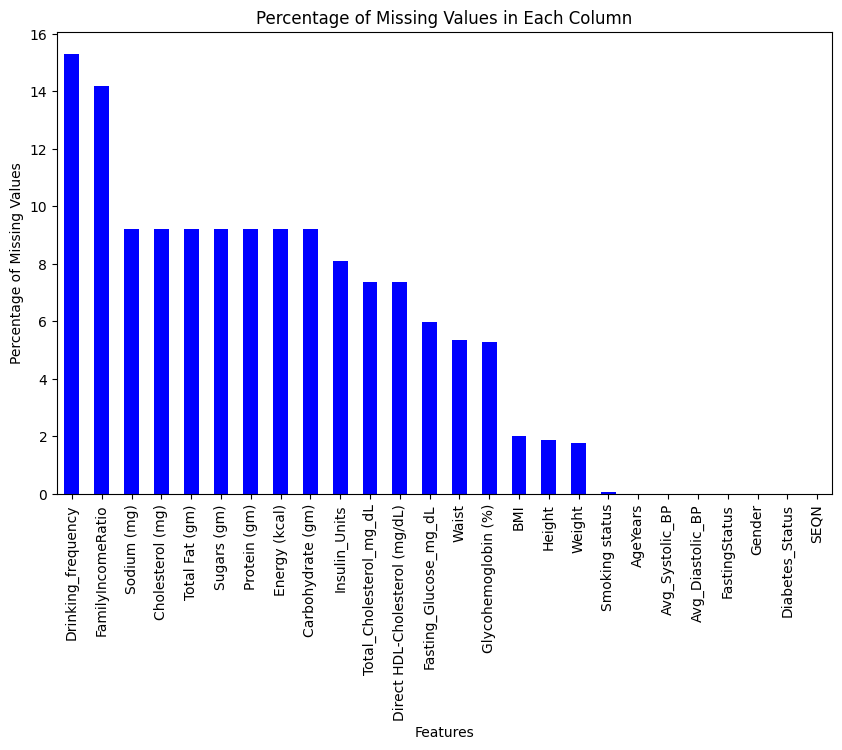

In [ ]:
#missing data visualisation
missing_percentages.plot(kind='bar', figsize=(10, 6), color = 'blue')
plt.title("Percentage of Missing Values in Each Column")
plt.xlabel("Features")
plt.ylabel("Percentage of Missing Values")

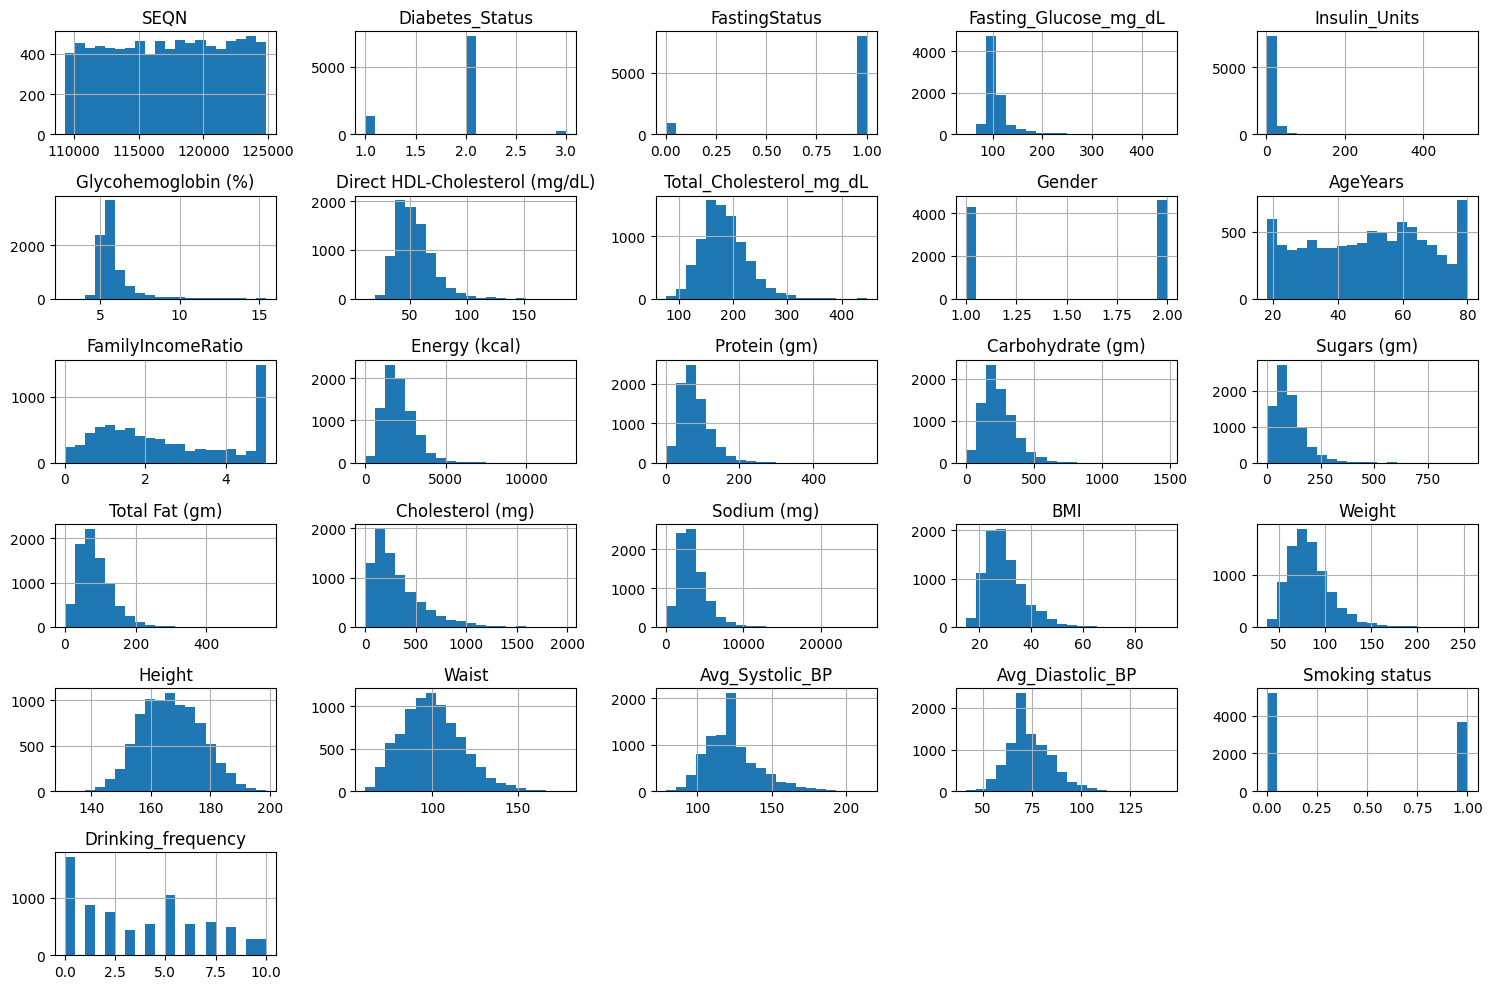

In [ ]:
#feature distribution visualisation
# Plot histograms for key variables
merged_df.hist(bins=20, figsize=(15, 10))
plt.tight_layout()
plt.show()

In [ ]:
# Map to binary: Include borderline as diabetic (1)
merged_df['Diabetes_Status_Binary'] = merged_df['Diabetes_Status'].map({
    1: 1,  # Yes -> Diabetic
    2: 0,  # No -> Non-Diabetic
    3: 0,  # Borderline -> Diabetic
    7: np.nan,  # Refused -> Exclude
    9: np.nan   # Don't Know -> Exclude
})

In [ ]:
# counting the diabetes status distribution
# Drop rows with missing or invalid Diabetes_Status
merged_df = merged_df.dropna(subset=['Diabetes_Status_Binary'])

# Check the updated value counts
print("Updated Diabetes_Status_Binary Value Counts:")
print(merged_df['Diabetes_Status_Binary'].value_counts())


Updated Diabetes_Status_Binary Value Counts:
Diabetes_Status_Binary
0.0    7486
1.0    1386
Name: count, dtype: int64


<ipython-input-42-5d05e635ded7>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Diabetes_Status_Binary', data=merged_df, palette='viridis')


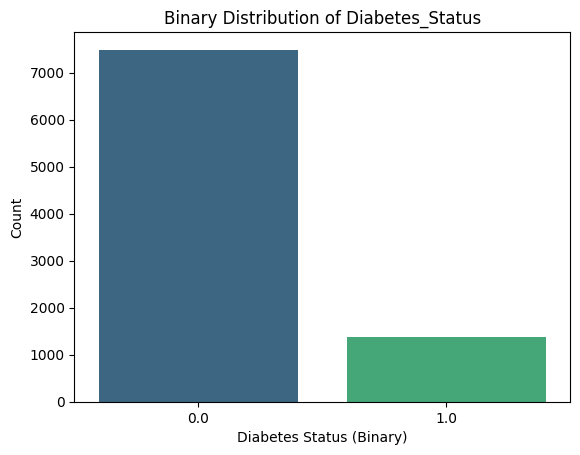

In [ ]:
#diabetes status visualisaton
# Visualize binary distribution
sns.countplot(x='Diabetes_Status_Binary', data=merged_df, palette='viridis')
plt.title('Binary Distribution of Diabetes_Status')
plt.xlabel('Diabetes Status (Binary)')
plt.ylabel('Count')
plt.show()

In [ ]:
merged_df.drop('Diabetes_Status', axis=1, inplace=True)
merged_df.rename(columns={'Diabetes_Status_Binary': 'Diabetes_Status'}, inplace=True)
merged_df.head()

,SEQN,FastingStatus,Fasting_Glucose_mg_dL,Insulin_Units,Glycohemoglobin (%),Direct HDL-Cholesterol (mg/dL),Total_Cholesterol_mg_dL,Gender,AgeYears,FamilyIncomeRatio,...,Sodium (mg),BMI,Weight,Height,Waist,Avg_Systolic_BP,Avg_Diastolic_BP,Smoking status,Drinking_frequency,Diabetes_Status
0,109271,1,103.0,16.96,5.6,33.0,147.0,1,49,NaN,...,5446.0,29.7,98.8,182.3,120.4,107.000000,67.000000,1.0,0.0,0.0
1,109274,1,154.0,13.52,5.7,29.0,105.0,1,68,1.20,...,6717.0,30.2,103.7,185.3,109.6,134.000000,70.000000,0.0,7.0,1.0
2,109282,1,95.0,7.49,5.5,43.0,233.0,1,76,3.61,...,2456.0,26.6,83.3,177.1,NaN,139.333333,72.666667,1.0,0.0,0.0
3,109286,0,92.0,16.46,5.7,67.0,236.0,2,33,1.36,...,7251.0,28.9,72.6,158.4,NaN,119.806263,71.599455,0.0,NaN,0.0
4,109290,1,106.0,20.25,8.4,40.0,165.0,2,68,5.00,...,1059.0,28.1,73.0,161.2,92.0,121.333333,60.333333,0.0,0.0,1.0


In [ ]:
merged_df.to_csv('binary_lab_lifestyle_data.csv', index=False)

In [ ]:
b_df = pd.read_csv('/content/drive/MyDrive/final_nhanes_data/binary_lab_lifestyle_data.csv')
b_df.head()

,SEQN,FastingStatus,Fasting_Glucose_mg_dL,Insulin_Units,Glycohemoglobin (%),Direct HDL-Cholesterol (mg/dL),Total_Cholesterol_mg_dL,Gender,AgeYears,FamilyIncomeRatio,...,Sodium (mg),BMI,Weight,Height,Waist,Avg_Systolic_BP,Avg_Diastolic_BP,Smoking status,Drinking_frequency,Diabetes_Status
0,109271,1,103.0,16.96,5.6,33.0,147.0,1,49,NaN,...,5446.0,29.7,98.8,182.3,120.4,107.000000,67.000000,1.0,0.0,0.0
1,109274,1,154.0,13.52,5.7,29.0,105.0,1,68,1.20,...,6717.0,30.2,103.7,185.3,109.6,134.000000,70.000000,0.0,7.0,1.0
2,109282,1,95.0,7.49,5.5,43.0,233.0,1,76,3.61,...,2456.0,26.6,83.3,177.1,NaN,139.333333,72.666667,1.0,0.0,0.0
3,109286,0,92.0,16.46,5.7,67.0,236.0,2,33,1.36,...,7251.0,28.9,72.6,158.4,NaN,119.806263,71.599455,0.0,NaN,0.0
4,109290,1,106.0,20.25,8.4,40.0,165.0,2,68,5.00,...,1059.0,28.1,73.0,161.2,92.0,121.333333,60.333333,0.0,0.0,1.0


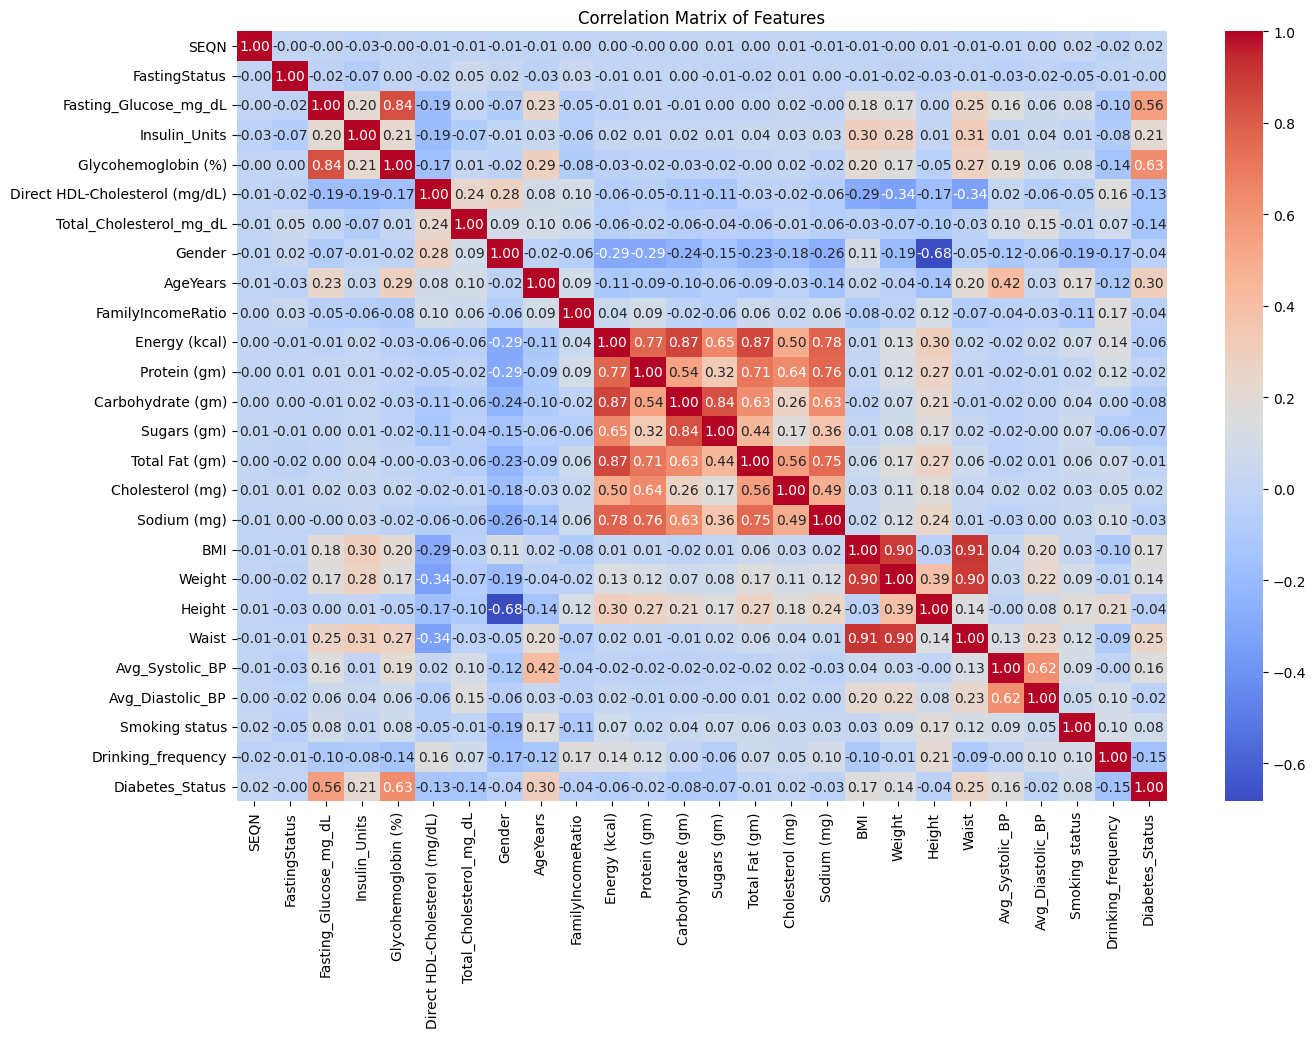

In [ ]:
# feature correlation matrix
correlation_matrix = b_df.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Features")
plt.show()

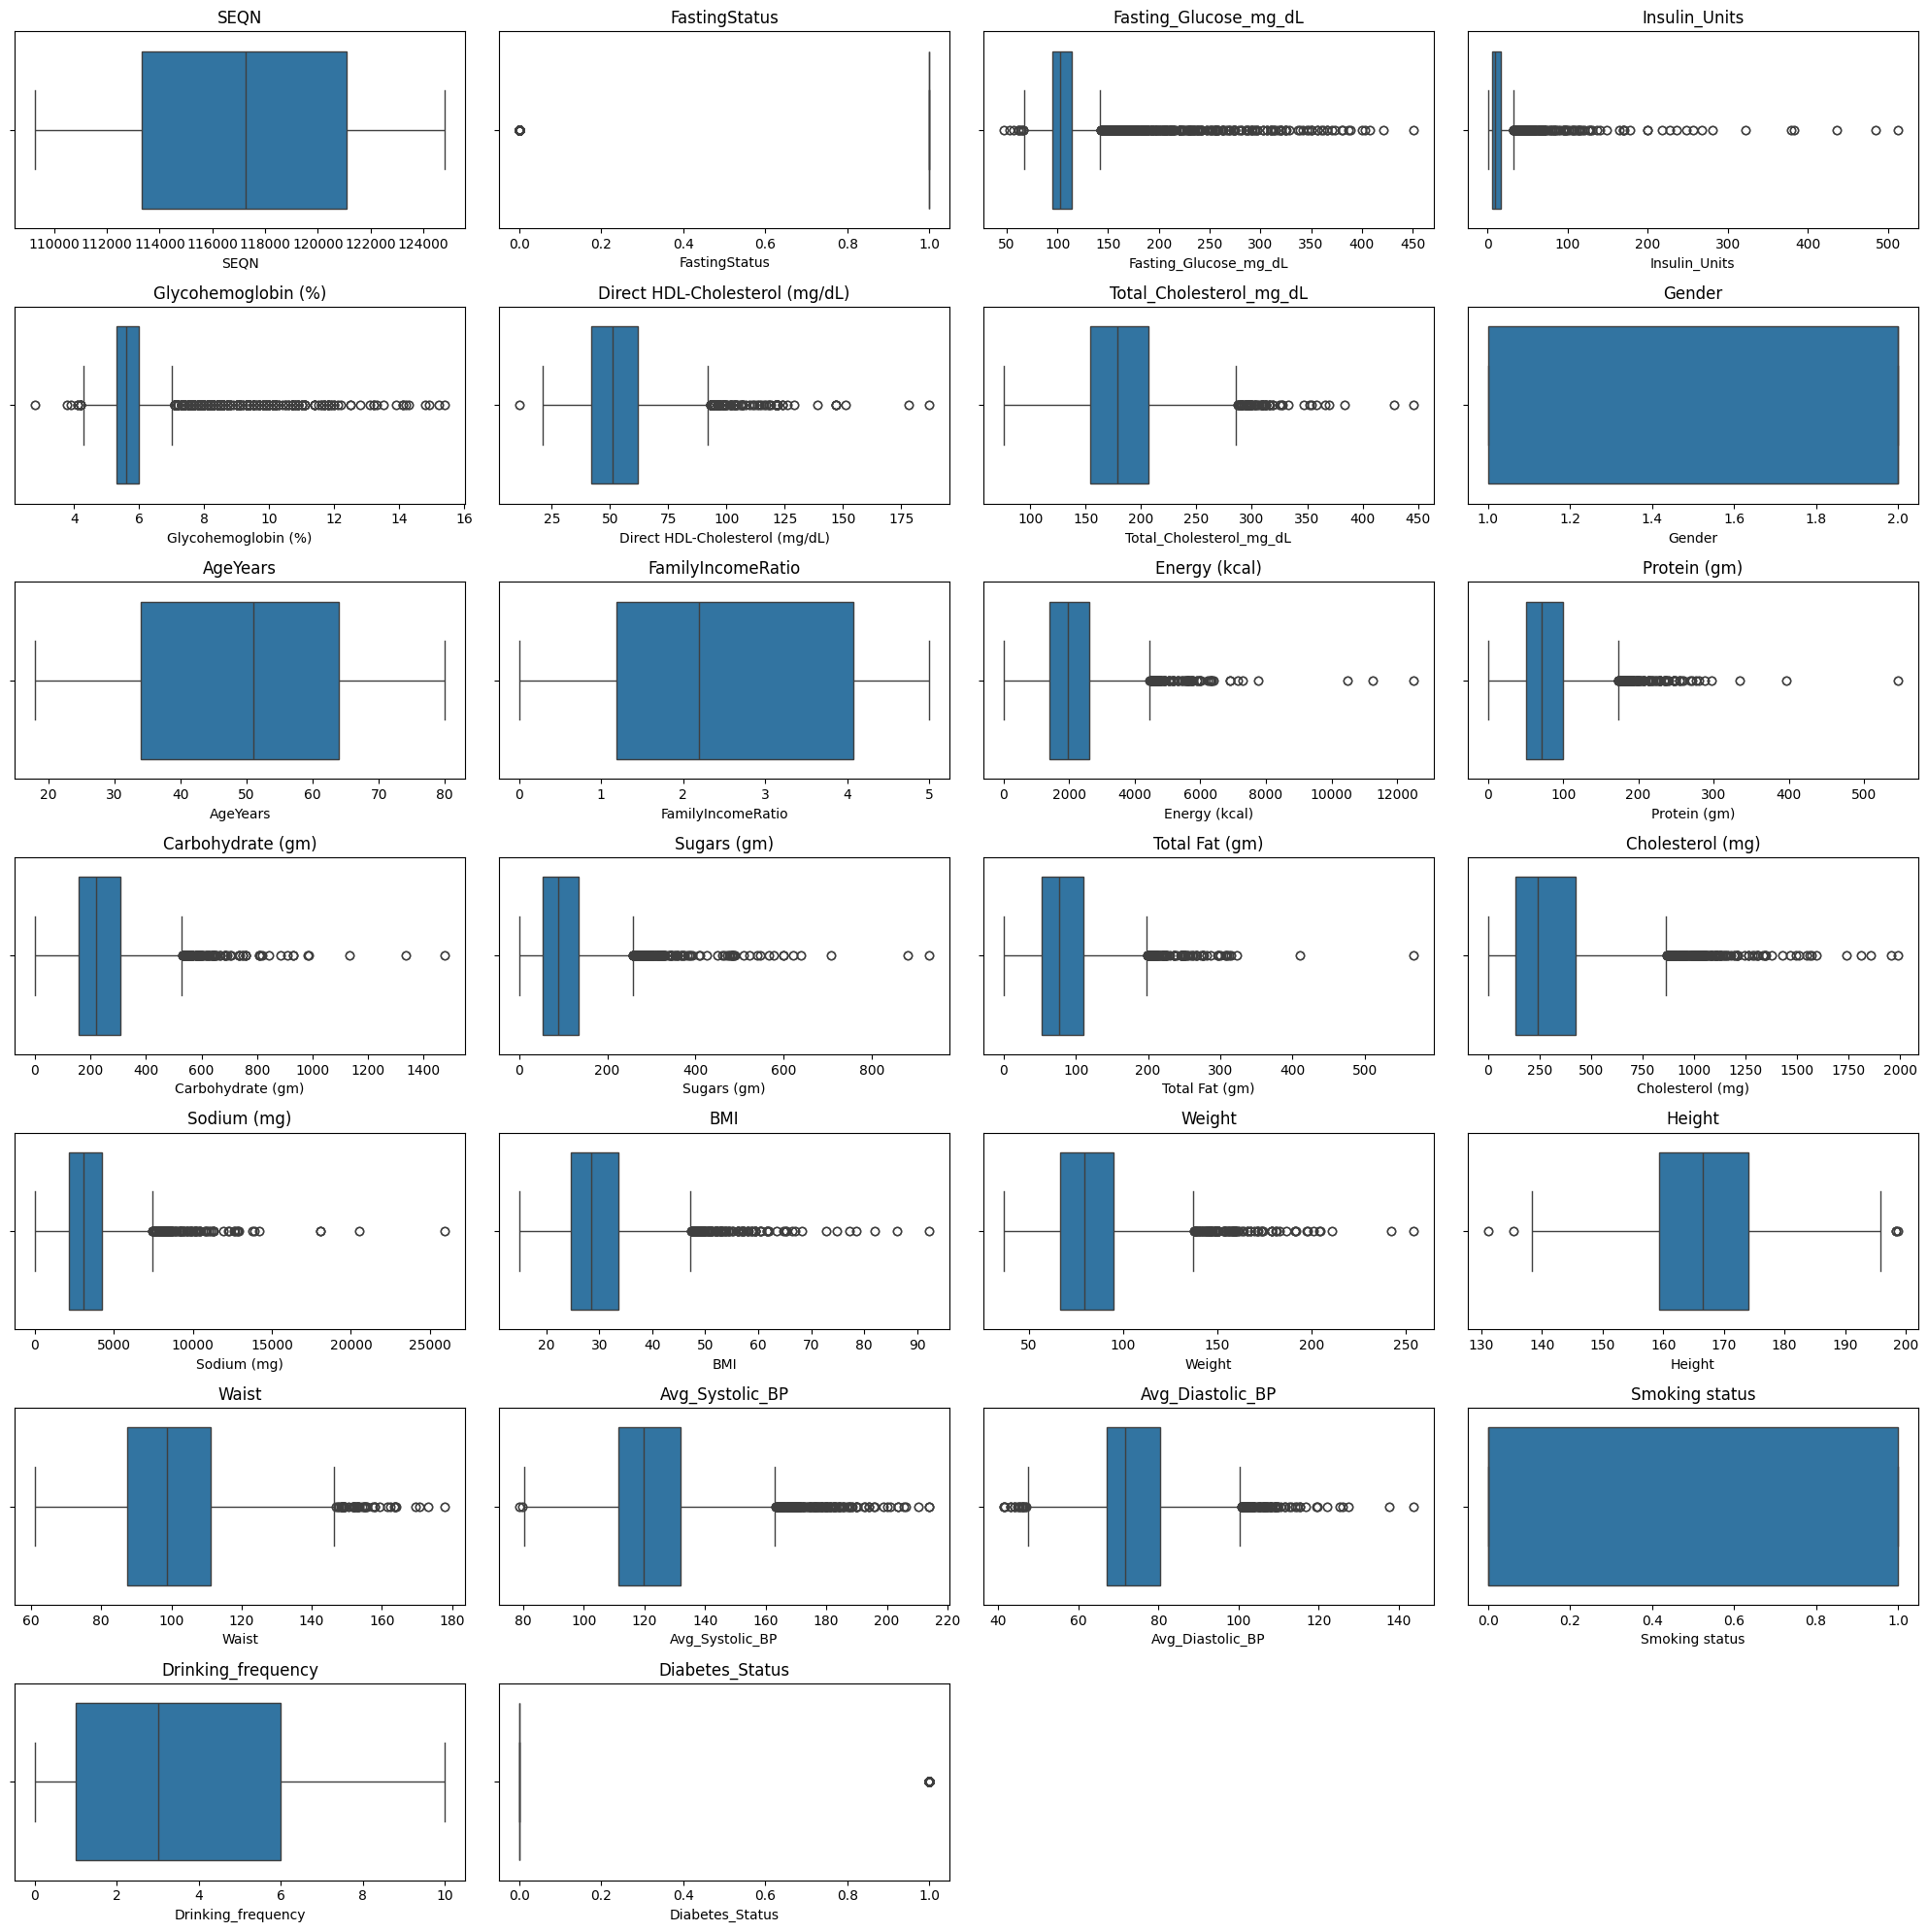

In [ ]:
# Plot boxplots for numerical features
numerical_features = b_df.select_dtypes(include=['float64', 'int64']).columns
plt.figure(figsize=(20, 20))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(7, 4, i)  # Adjust rows/columns based on number of features
    sns.boxplot(x=merged_df[feature])
    plt.title(feature)

plt.tight_layout()
plt.show()


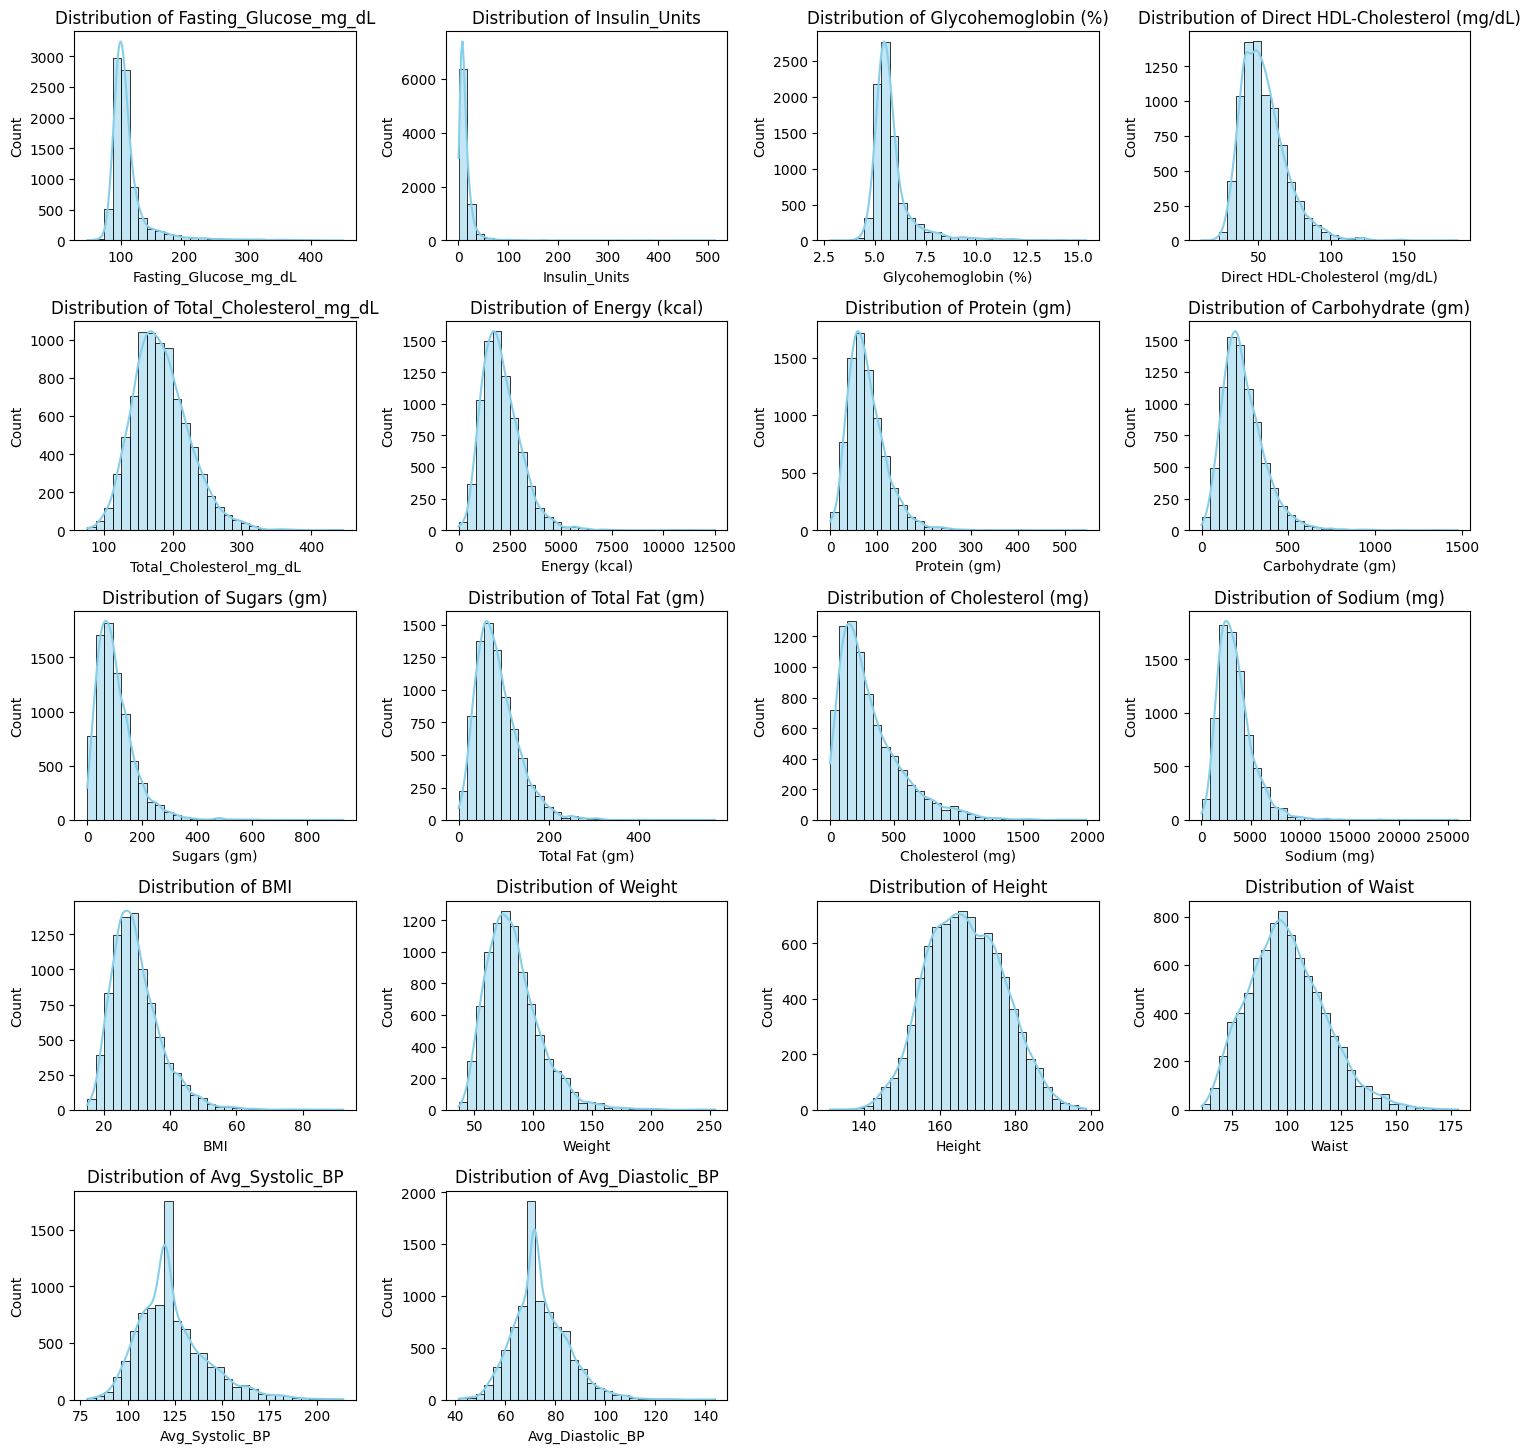

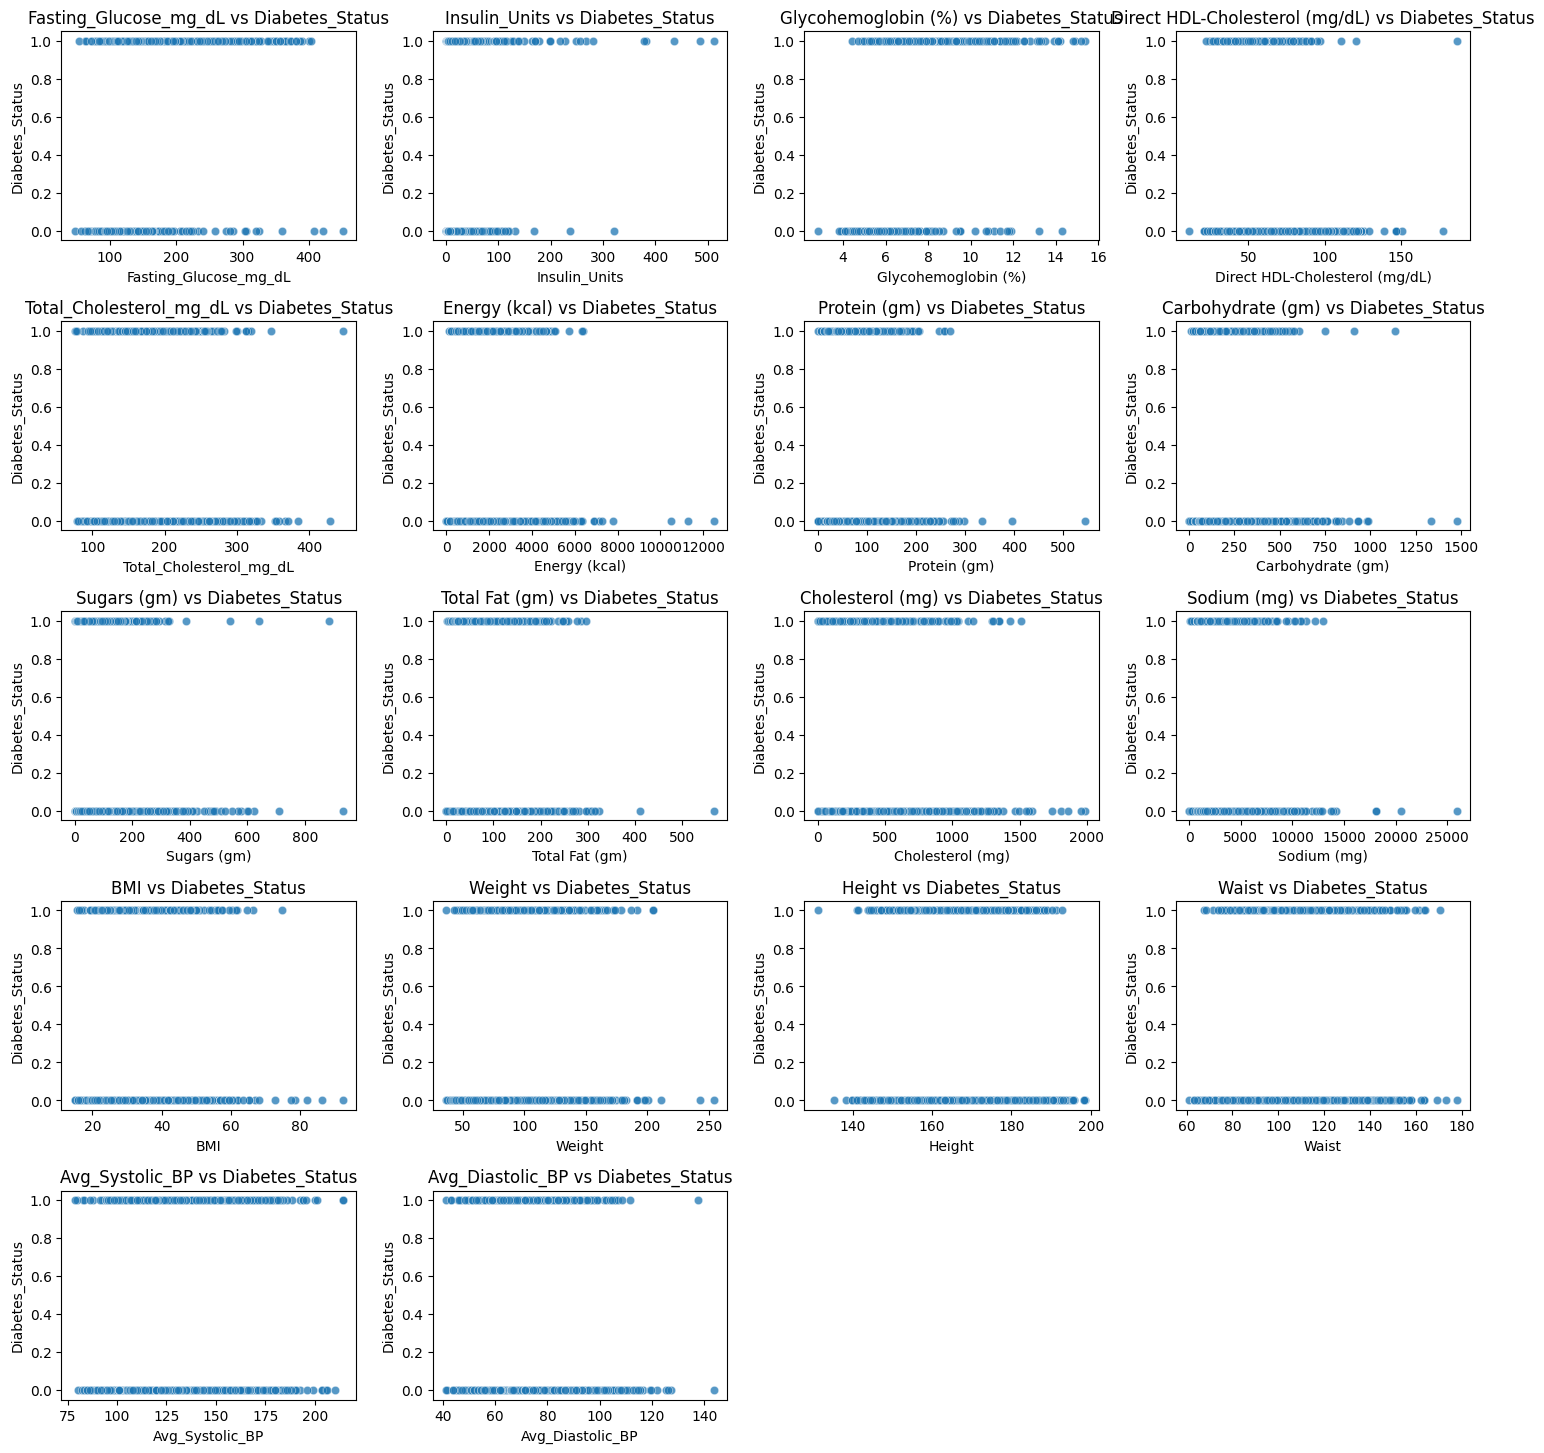

In [ ]:

# List of features to visualize
features = [ 'Fasting_Glucose_mg_dL', 'Insulin_Units', 'Glycohemoglobin (%)',
    'Direct HDL-Cholesterol (mg/dL)', 'Total_Cholesterol_mg_dL',
    'Energy (kcal)', 'Protein (gm)', 'Carbohydrate (gm)', 'Sugars (gm)',
    'Total Fat (gm)', 'Cholesterol (mg)', 'Sodium (mg)', 'BMI',
    'Weight', 'Height', 'Waist', 'Avg_Systolic_BP', 'Avg_Diastolic_BP']

# Create histograms for the selected features
def plot_histograms(data, features):
    plt.figure(figsize=(15, 20))
    for i, feature in enumerate(features, 1):
        plt.subplot(7, 4, i)
        sns.histplot(data[feature], bins=30, kde=True, color='skyblue')
        plt.title(f'Distribution of {feature}')
    plt.tight_layout()
    plt.show()

# Scatter plots for feature vs Diabetes_Status
def plot_scatter(data, features, target='Diabetes_Status'):
    plt.figure(figsize=(15, 20))
    for i, feature in enumerate(features, 1):
        plt.subplot(7, 4, i)
        sns.scatterplot(x=feature, y=target, data=data, alpha=0.5)
        plt.title(f'{feature} vs {target}')
    plt.tight_layout()
    plt.show()

# Call the functions
plot_histograms(b_df, features)
plot_scatter(b_df, features, target='Diabetes_Status')

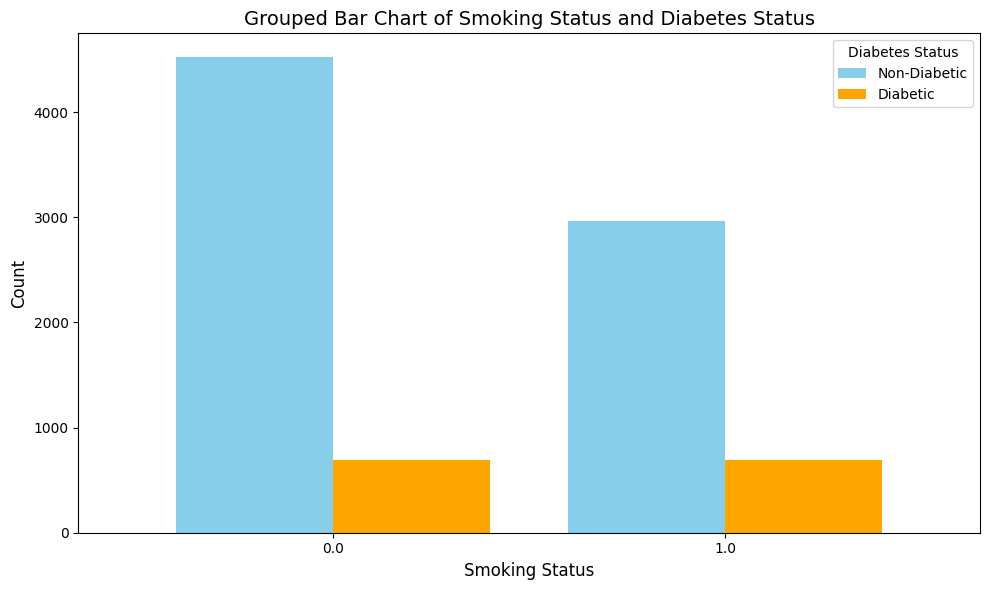

In [ ]:

# Example: Assuming you have a DataFrame `data` with 'Smoking_Status' and 'Diabetes_Status'
# Replace 'Smoking_Status' and 'Diabetes_Status' with the actual column names in your dataset.

# Calculate the counts for each combination of the two binary variables
stacked_data = b_df.groupby(['Smoking status', 'Diabetes_Status']).size().unstack()

# Plot a grouped bar chart
stacked_data.plot(kind='bar', figsize=(10, 6), color=['skyblue', 'orange'], width=0.8)
# Plot a stacked bar chart


# Add labels and title
plt.xlabel('Smoking Status', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Grouped Bar Chart of Smoking Status and Diabetes Status', fontsize=14)
plt.xticks(rotation=0)
plt.legend(['Non-Diabetic', 'Diabetic'], title='Diabetes Status')

# Show the plot
plt.tight_layout()
plt.show()

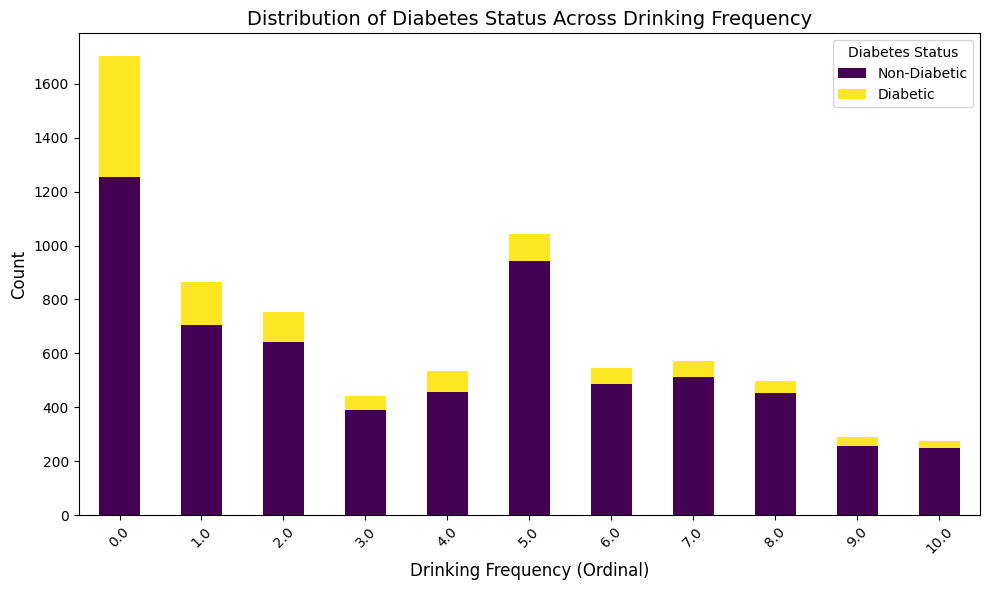

In [ ]:
#Visualise the relationship between drinking frequency and diabetes
# Create a grouped DataFrame to calculate counts of Diabetes_Status for each Drinking_Frequency
grouped = b_df.groupby(['Drinking_frequency', 'Diabetes_Status']).size().unstack()

# Plot a stacked bar chart
grouped.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')

# Add titles and labels
plt.title('Distribution of Diabetes Status Across Drinking Frequency', fontsize=14)
plt.xlabel('Drinking Frequency (Ordinal)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Diabetes Status', labels=['Non-Diabetic', 'Diabetic'])
plt.tight_layout()
plt.show()


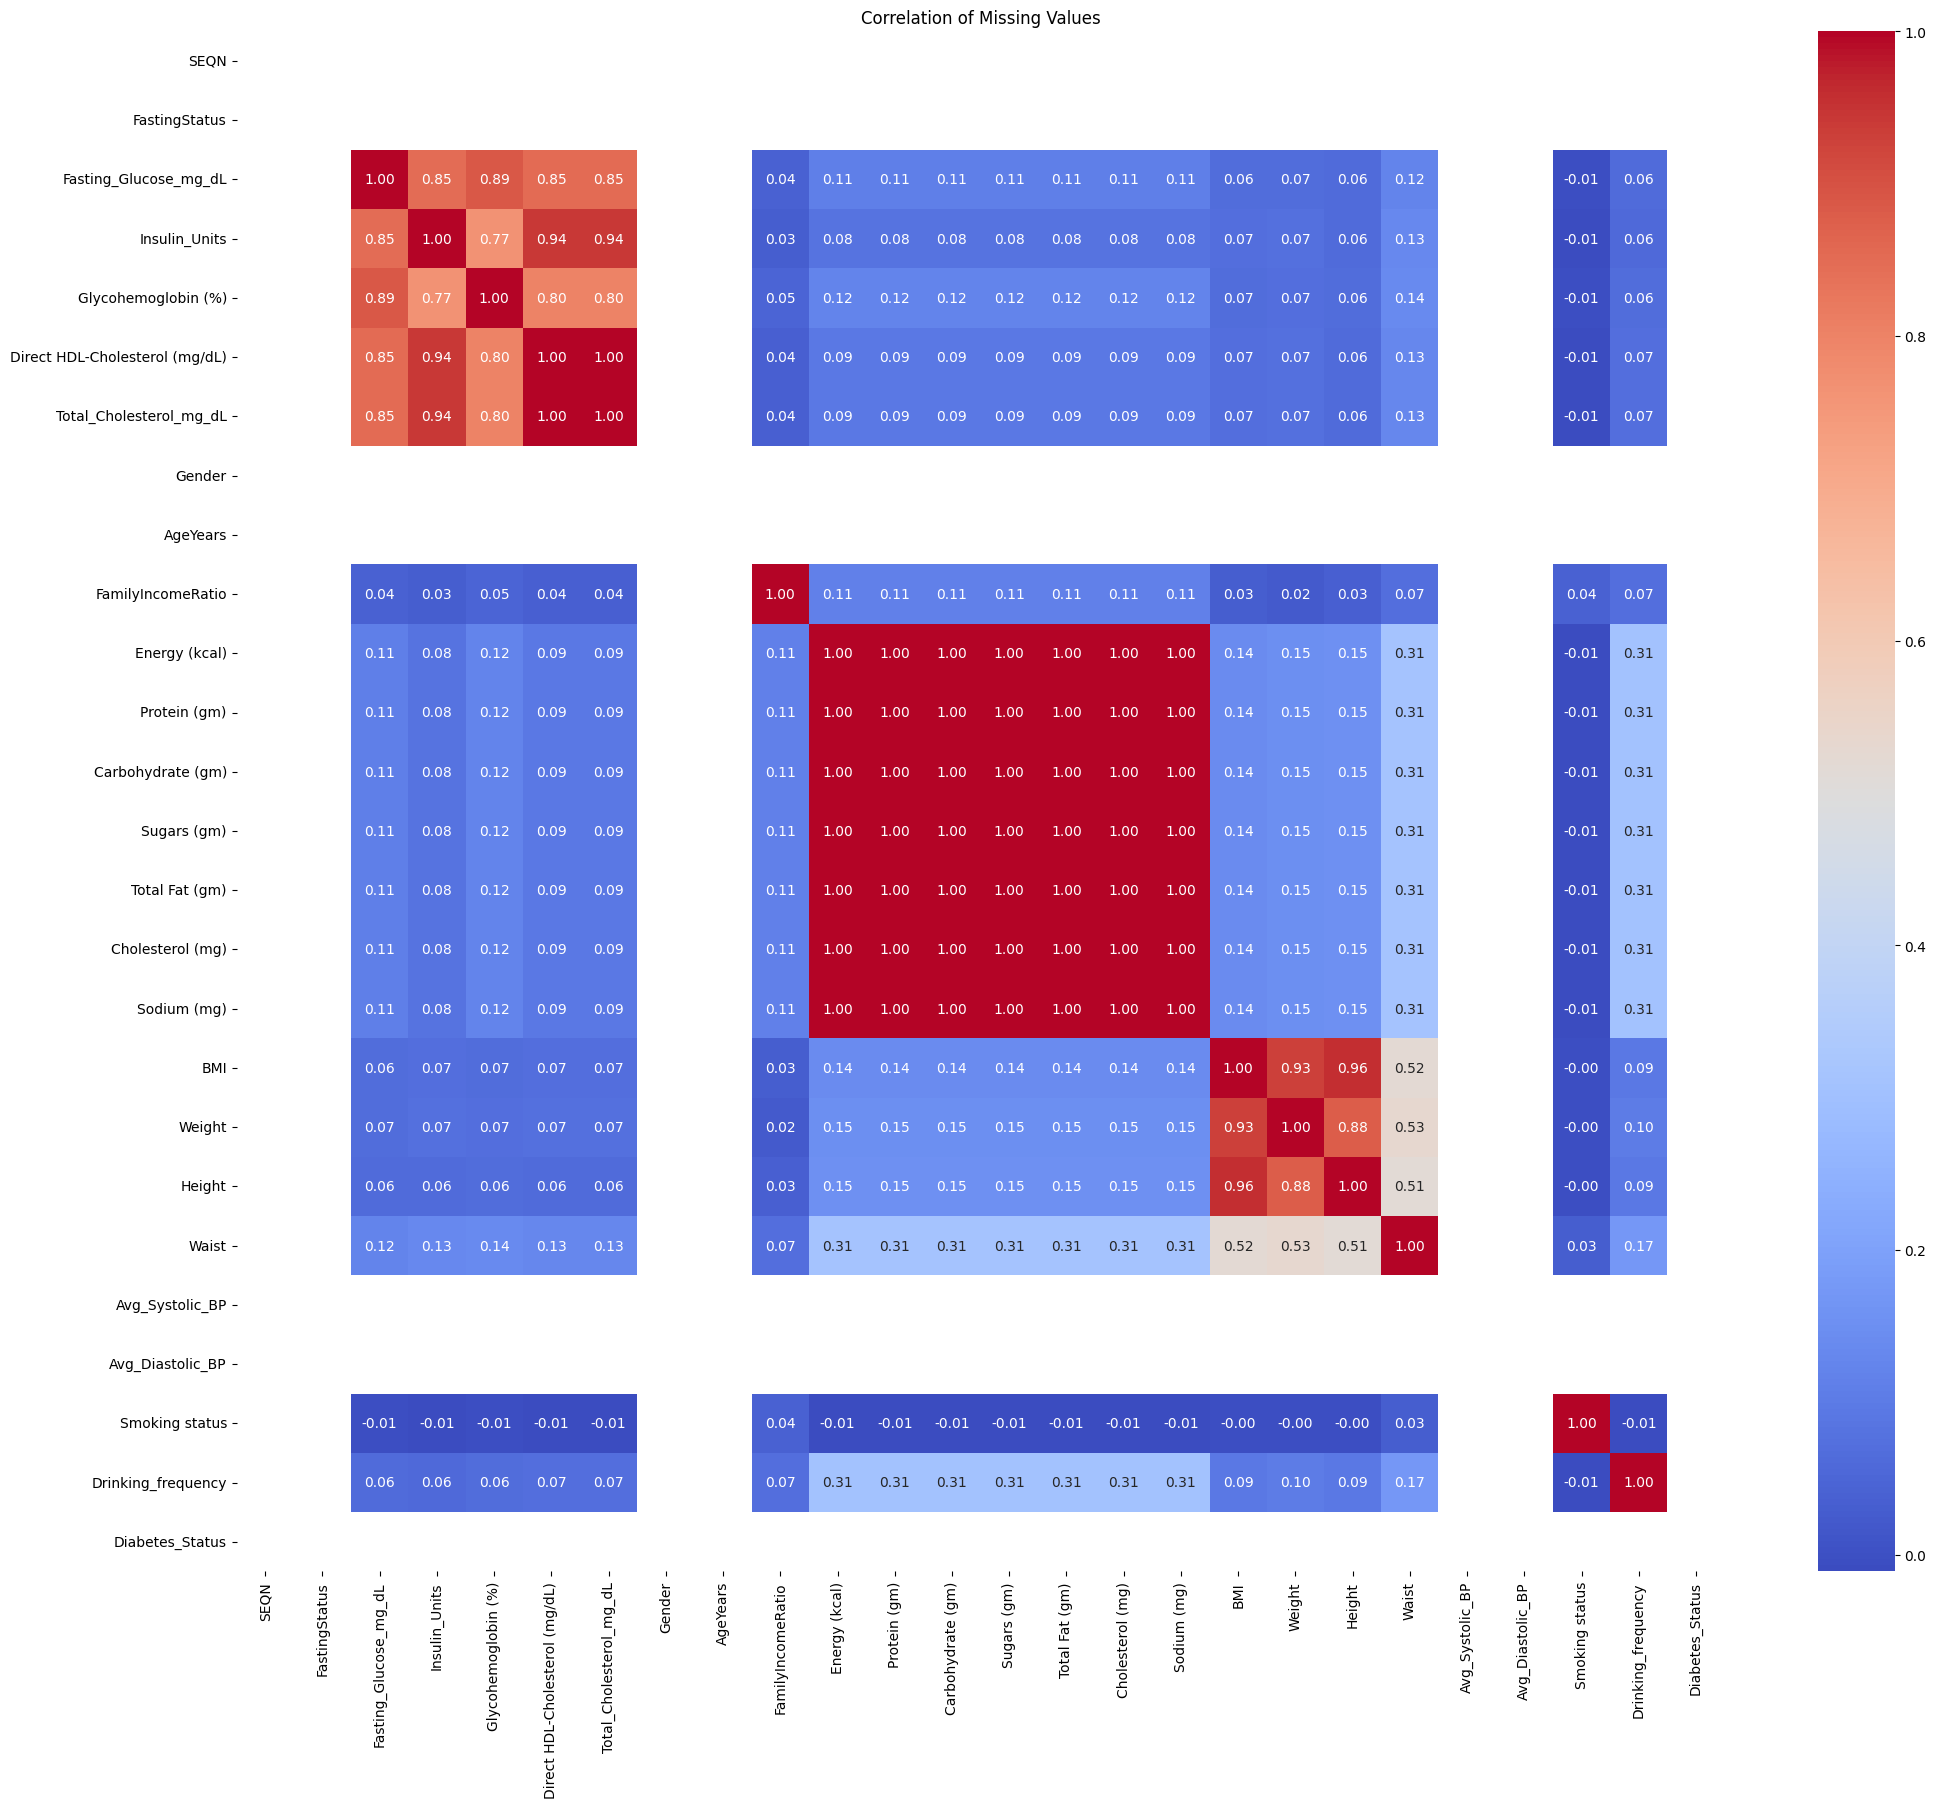

In [ ]:
# Correlation of missing values

missing_corr = b_df.isnull().corr()

plt.figure(figsize=(24,20))
sns.heatmap(missing_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation of Missing Values")
plt.show()

##**Pre-processing**

#Imputing missing values

In [ ]:
b_df = pd.read_csv('/content/drive/MyDrive/final_nhanes_data/binary_lab_lifestyle_data.csv')
b_df.head()

,SEQN,FastingStatus,Fasting_Glucose_mg_dL,Insulin_Units,Glycohemoglobin (%),Direct HDL-Cholesterol (mg/dL),Total_Cholesterol_mg_dL,Gender,AgeYears,FamilyIncomeRatio,...,Sodium (mg),BMI,Weight,Height,Waist,Avg_Systolic_BP,Avg_Diastolic_BP,Smoking status,Drinking_frequency,Diabetes_Status
0,109271,1,103.0,16.96,5.6,33.0,147.0,1,49,NaN,...,5446.0,29.7,98.8,182.3,120.4,107.000000,67.000000,1.0,0.0,0.0
1,109274,1,154.0,13.52,5.7,29.0,105.0,1,68,1.20,...,6717.0,30.2,103.7,185.3,109.6,134.000000,70.000000,0.0,7.0,1.0
2,109282,1,95.0,7.49,5.5,43.0,233.0,1,76,3.61,...,2456.0,26.6,83.3,177.1,NaN,139.333333,72.666667,1.0,0.0,0.0
3,109286,0,92.0,16.46,5.7,67.0,236.0,2,33,1.36,...,7251.0,28.9,72.6,158.4,NaN,119.806263,71.599455,0.0,NaN,0.0
4,109290,1,106.0,20.25,8.4,40.0,165.0,2,68,5.00,...,1059.0,28.1,73.0,161.2,92.0,121.333333,60.333333,0.0,0.0,1.0


In [ ]:
# List of columns to impute
dietry_intake = b_df[['Energy (kcal)', 'Protein (gm)', 'Carbohydrate (gm)',
    'Sugars (gm)', 'Total Fat (gm)', 'Cholesterol (mg)', 'Sodium (mg)']]


b_df['FamilyIncomeRatio'] = b_df['FamilyIncomeRatio'].fillna(b_df['FamilyIncomeRatio'].mean())

weight_data = b_df[['BMI', 'Weight', 'Height', 'Waist']]
# Use KNN for numerical features with correlations
knn_imputer = KNNImputer(n_neighbors=5)

# Apply KNN imputer to the body measures features
b_df[weight_data.columns]= knn_imputer.fit_transform(b_df[weight_data.columns])


# Apply KNN imputer to the dietry features
b_df[dietry_intake.columns] = knn_imputer.fit_transform(b_df[dietry_intake.columns])

# Impute smoking status and drinking frequency (categorical ordinal data)
# Use mode for categorical features
categorical_features = ['Smoking status', 'Drinking_frequency']
for col in categorical_features:
    b_df[col].fillna(b_df[col].mode()[0], inplace=True)

# Step 1: Direct Imputation for Cholesterol values
b_df['Direct HDL-Cholesterol (mg/dL)'] = b_df['Direct HDL-Cholesterol (mg/dL)'].fillna(
    b_df['Total_Cholesterol_mg_dL']
)
b_df['Total_Cholesterol_mg_dL'] = b_df['Total_Cholesterol_mg_dL'].fillna(
    b_df['Direct HDL-Cholesterol (mg/dL)']
)
imputed_data = knn_imputer.fit_transform(b_df[['Fasting_Glucose_mg_dL', 'Insulin_Units', 'Glycohemoglobin (%)']])

# Assign imputed values back to the dataset
b_df[['Fasting_Glucose_mg_dL', 'Insulin_Units', 'Glycohemoglobin (%)']] = imputed_data




<ipython-input-3-8c94cdb9cf9c>:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  b_df[col].fillna(b_df[col].mode()[0], inplace=True)


In [ ]:
#  Verify no missing values remain
print("Missing values after imputation:")
print(b_df.isnull().sum())

Missing values after imputation:
SEQN                                0
FastingStatus                       0
Fasting_Glucose_mg_dL               0
Insulin_Units                       0
Glycohemoglobin (%)                 0
Direct HDL-Cholesterol (mg/dL)    654
Total_Cholesterol_mg_dL           654
Gender                              0
AgeYears                            0
FamilyIncomeRatio                   0
Energy (kcal)                       0
Protein (gm)                        0
Carbohydrate (gm)                   0
Sugars (gm)                         0
Total Fat (gm)                      0
Cholesterol (mg)                    0
Sodium (mg)                         0
BMI                                 0
Weight                              0
Height                              0
Waist                               0
Avg_Systolic_BP                     0
Avg_Diastolic_BP                    0
Smoking status                      0
Drinking_frequency                  0
Diabetes_Status  

In [ ]:
# Apply KNN Imputation for remaining columns
#knn_imputer = KNNImputer(n_neighbors=5)

#  columns to impute
columns_to_impute = ['Direct HDL-Cholesterol (mg/dL)', 'Total_Cholesterol_mg_dL']
b_df[columns_to_impute] = knn_imputer.fit_transform(b_df[columns_to_impute])


In [ ]:
#  Verify no missing values remain
print("Missing values after imputation:")
print(b_df.isnull().sum())

Missing values after imputation:
SEQN                              0
FastingStatus                     0
Fasting_Glucose_mg_dL             0
Insulin_Units                     0
Glycohemoglobin (%)               0
Direct HDL-Cholesterol (mg/dL)    0
Total_Cholesterol_mg_dL           0
Gender                            0
AgeYears                          0
FamilyIncomeRatio                 0
Energy (kcal)                     0
Protein (gm)                      0
Carbohydrate (gm)                 0
Sugars (gm)                       0
Total Fat (gm)                    0
Cholesterol (mg)                  0
Sodium (mg)                       0
BMI                               0
Weight                            0
Height                            0
Waist                             0
Avg_Systolic_BP                   0
Avg_Diastolic_BP                  0
Smoking status                    0
Drinking_frequency                0
Diabetes_Status                   0
dtype: int64


##Handling outliers by clipping

In [ ]:

# List of columns with outliers to Winsorize
columns_to_winsorize = [
    'Fasting_Glucose_mg_dL', 'Insulin_Units', 'Glycohemoglobin (%)',
    'Direct HDL-Cholesterol (mg/dL)', 'Total_Cholesterol_mg_dL',
    'Energy (kcal)', 'Protein (gm)', 'Carbohydrate (gm)',
    'Sugars (gm)', 'Total Fat (gm)', 'Cholesterol (mg)',
    'Sodium (mg)', 'BMI', 'Weight', 'Height',
    'Waist', 'Avg_Systolic_BP', 'Avg_Diastolic_BP'
]

# Apply Winsorization
for col in columns_to_winsorize:
    lower_limit, upper_limit = 0.01, 0.01  # Capping at 1% lower and upper ends
    b_df[col] = winsorize(b_df[col], limits=(lower_limit, upper_limit))



In [ ]:
b_df.to_csv('preprocessed_lab_lifestyle.csv', index=False)

#**Machine learning Model**

#Data split

In [38]:
p_df = pd.read_csv('/content/preprocessed_lab_lifestyle.csv')


In [39]:

# Drop SEQN (ID column) and separate features and target
X = p_df.drop(['Diabetes_Status', 'SEQN'], axis=1)
y = p_df['Diabetes_Status']

# Split the data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

##SMOTE to balance the data

In [40]:
y_counter = Counter(y_train)
print("Class distribution before SMOTE:", y_counter)

# Initialize SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
y_counter_resampled = Counter(y_train_resampled)
print("Class distribution after SMOTE:", y_counter_resampled)


Class distribution before SMOTE: Counter({0.0: 5240, 1.0: 970})
Class distribution after SMOTE: Counter({0.0: 5240, 1.0: 5240})


##**Random Forest Model**

In [50]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=100, class_weight='balanced')

# Apply RFE for feature selection
rfe = RFE(estimator=rf, n_features_to_select=14)  # Choose top 14 features
rfe.fit(X_train_resampled, y_train_resampled)

# Get the selected features
selected_features = X.columns[rfe.support_]
print("Selected Features:", selected_features)

# Create a new dataset with selected features
X_train_selected = X_train_resampled[selected_features]
X_val_selected = X_val[selected_features]
X_test_selected = X_test[selected_features]

# Train Random Forest on selected features
rf.fit(X_train_selected, y_train_resampled)

# Evaluate the model on the validation set
y_val_pred1 = rf.predict(X_val_selected)

print("\nValidation Results:")
print(classification_report(y_val, y_val_pred1))

Selected Features: Index(['Fasting_Glucose_mg_dL', 'Insulin_Units', 'Glycohemoglobin (%)',
       'Total_Cholesterol_mg_dL', 'AgeYears', 'Sugars (gm)', 'Sodium (mg)',
       'BMI', 'Height', 'Waist', 'Avg_Systolic_BP', 'Avg_Diastolic_BP',
       'Smoking status', 'Drinking_frequency'],
      dtype='object')

Validation Results:
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98      1123
         1.0       0.93      0.90      0.91       208

    accuracy                           0.97      1331
   macro avg       0.95      0.95      0.95      1331
weighted avg       0.97      0.97      0.97      1331



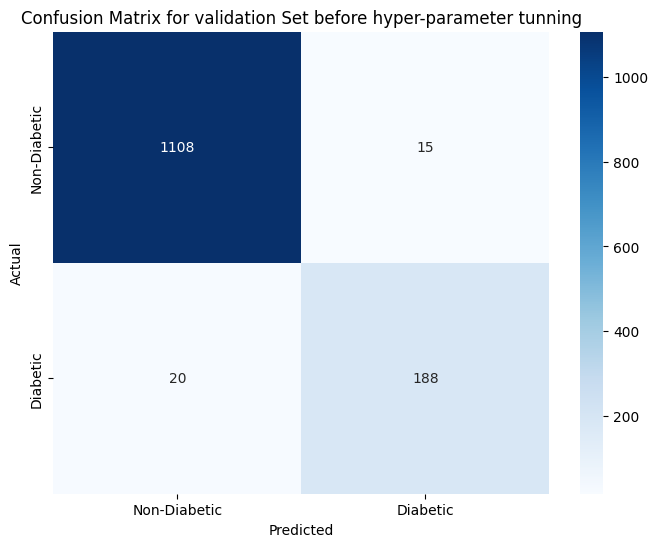

In [55]:
# Plot Confusion Matrix
def plot_confusion_matrix(y_val, y_val_pred1, title="Confusion Matrix"):
    cm = confusion_matrix(y_val, y_val_pred1)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Diabetic', 'Diabetic'],
                yticklabels=['Non-Diabetic', 'Diabetic'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

plot_confusion_matrix(y_val, y_val_pred1, title="Confusion Matrix for validation Set before hyper-parameter tunning")

Hyperparameter Tunning

In [52]:


# Define the parameter grid
param_grid = {
    'n_estimators': [90, 100, 200, 500],
    'max_depth': [None, 10, 20, 30, 50],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['sqrt', 'log2', None]
}
from sklearn.model_selection import RandomizedSearchCV

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=10,  # Number of random combinations to try
    scoring='f1_weighted',
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=2
)
random_search.fit(X_train_selected, y_train_resampled)


# Best hyperparameters and estimator
print("Best Parameters:", random_search.best_params_)
best_rf_model = random_search.best_estimator_

# Evaluate on the validation set
y_val_pred = best_rf_model.predict(X_val_selected)
print("\nValidation Results After Hyperparameter Tuning:")
print(classification_report(y_val, y_val_pred))



Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'n_estimators': 90, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 50}

Validation Results After Hyperparameter Tuning:
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98      1123
         1.0       0.91      0.89      0.90       208

    accuracy                           0.97      1331
   macro avg       0.95      0.94      0.94      1331
weighted avg       0.97      0.97      0.97      1331



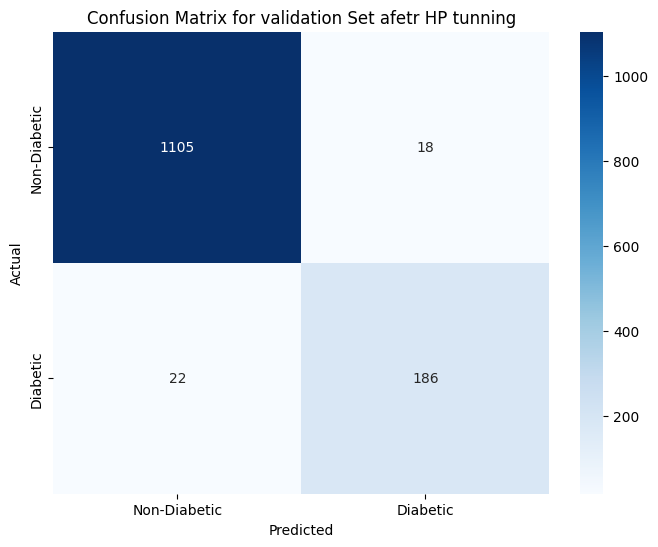

In [56]:
# Plot Confusion Matrix
def plot_confusion_matrix(y_val, y_val_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_val, y_val_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Diabetic', 'Diabetic'],
                yticklabels=['Non-Diabetic', 'Diabetic'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

plot_confusion_matrix(y_val, y_val_pred, title="Confusion Matrix for validation Set afetr HP tunning")

In [61]:
y_test_pred_best = rf.predict(X_test_selected)
print("\nTest Results:")
print(classification_report(y_test, y_test_pred_best))


Test Results:
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98      1123
         1.0       0.93      0.89      0.91       208

    accuracy                           0.97      1331
   macro avg       0.95      0.94      0.95      1331
weighted avg       0.97      0.97      0.97      1331



In [63]:
# Random Forest ROC
rf_y_test_pred_prob = rf.predict_proba(X_test_selected)[:, 1]  # Probabilities for positive class
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_y_test_pred_prob)
rf_auc = auc(rf_fpr, rf_tpr)

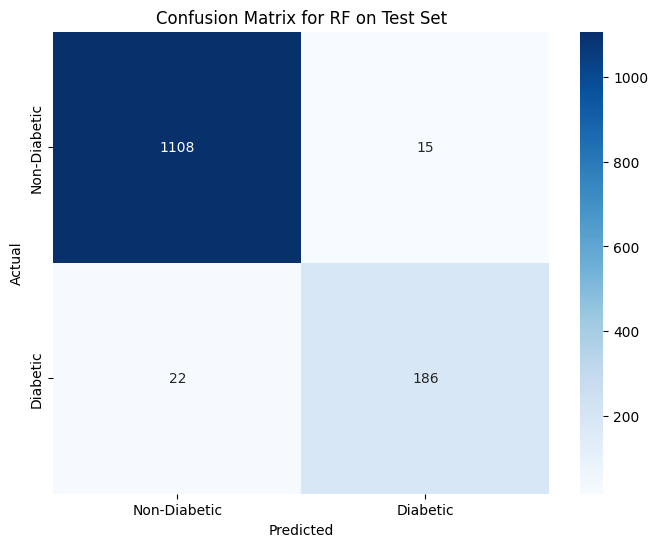

In [62]:

# Plot Confusion Matrix
def plot_confusion_matrix(y_test, y_tesy_pred_best, title="Confusion Matrix"):
    cm = confusion_matrix(y_test, y_test_pred_best)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Diabetic', 'Diabetic'],
                yticklabels=['Non-Diabetic', 'Diabetic'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

plot_confusion_matrix(y_test, y_test_pred_best, title="Confusion Matrix for RF on Test Set")

#**Deep** **Neural** **Network**

#**Preprocessing** **for** **deep** **learning**

#One_hot encoding for non_binary features

In [16]:


# Load dataset
file_path = '/content/preprocessed_lab_lifestyle.csv'
data = pd.read_csv(file_path)

# Separate features (X) and target (y)
target_column = 'Diabetes_Status'
X = data.drop(columns=[target_column])
y = data[target_column]

# Handle categorical columns
categorical_columns = ['Gender', 'Smoking status', 'Drinking_frequency']

# Check for missing values in categorical columns
for col in categorical_columns:
    if X[col].isnull().any():
        print(f"Missing values found in {col}. Filling with 'Unknown'.")
        X[col] = X[col].fillna('Unknown')

# One-hot encoding for non-binary categorical variables
one_hot_encoder = OneHotEncoder(drop='first', handle_unknown='ignore')  # Dropping first to avoid dummy variable trap
X_encoded = one_hot_encoder.fit_transform(X[categorical_columns])

# Convert encoded features to a DataFrame
X_encoded_df = pd.DataFrame(
    X_encoded.toarray(),
    columns=one_hot_encoder.get_feature_names_out(categorical_columns),
    index=X.index
)

# Drop original categorical columns and concatenate encoded ones
X = X.drop(columns=categorical_columns)
X = pd.concat([X, X_encoded_df], axis=1)

# Normalize/Standardize numerical columns
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)


# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE to the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check the class distribution before and after SMOTE
print("Class distribution before resampling:")
print(y_train.value_counts())
print("\nClass distribution after resampling:")
print(pd.Series(y_train_resampled).value_counts())

# Compute class weights (useful for neural networks)
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

# Print class weights
print("\nClass weights for Neural Networks:")
print(class_weight_dict)



Class distribution before resampling:
Diabetes_Status
0.0    5988
1.0    1109
Name: count, dtype: int64

Class distribution after resampling:
Diabetes_Status
0.0    5988
1.0    5988
Name: count, dtype: int64

Class weights for Neural Networks:
{0: 0.5926018704074816, 1: 3.1997294860234446}


In [26]:



# Define the model architecture
model = Sequential([
    Dense(128, input_dim=X_train_resampled.shape[1], activation='relu'),  # Input layer
    Dropout(0.3),  # Dropout for regularization
    Dense(64, activation='relu'),  # Hidden layer 1
    Dropout(0.3),
    Dense(32, activation='relu'),  # Hidden layer 2
    Dense(1, activation='sigmoid')  # Output layer (binary classification)
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Set up early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    X_train_resampled,
    y_train_resampled,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    class_weight=class_weight_dict,  # Apply class weights
    callbacks=[early_stopping],
    verbose=1
)





Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6654 - loss: 0.5583 - val_accuracy: 0.9729 - val_loss: 0.0949
Epoch 2/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8467 - loss: 0.3428 - val_accuracy: 0.9866 - val_loss: 0.0620
Epoch 3/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8501 - loss: 0.3164 - val_accuracy: 0.9837 - val_loss: 0.0794
Epoch 4/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8703 - loss: 0.2860 - val_accuracy: 0.9942 - val_loss: 0.0648
Epoch 5/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8823 - loss: 0.2601 - val_accuracy: 0.9958 - val_loss: 0.0609
Epoch 6/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8853 - loss: 0.2449 - val_accuracy: 0.9954 - val_loss: 0.0618
Epoch 7/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8980 - loss: 0.2270 - val_accuracy: 0.9946 - val_loss: 0.0463
Epoch 8/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8998 - loss: 0.2274 - val_accuracy: 0.9979 - val_

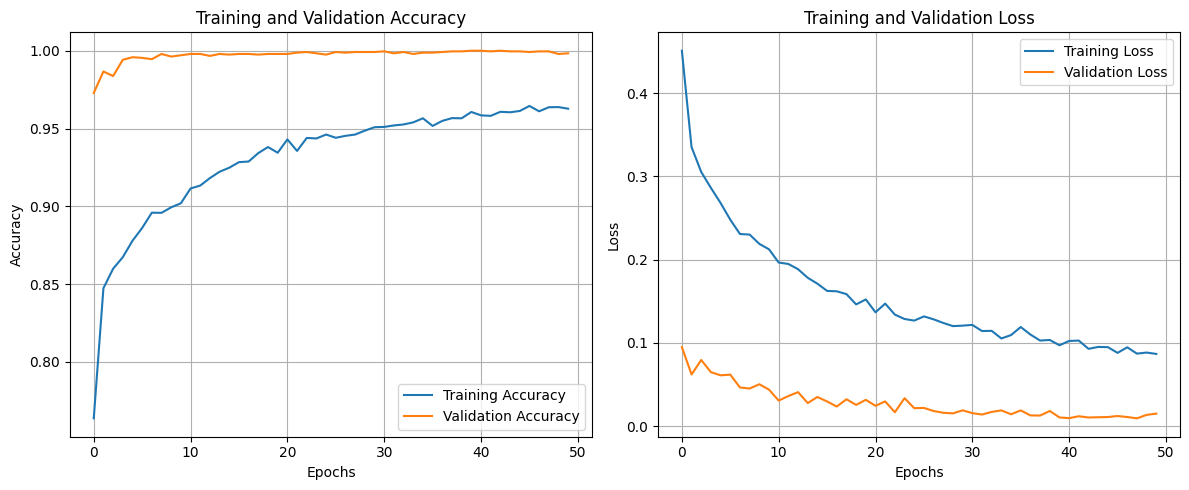

In [27]:


# Create a figure with two subplots for accuracy and loss
plt.figure(figsize=(12, 5))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Adjust layout and display the plots
plt.tight_layout()
plt.show()



In [29]:


def build_model(hp):
    model = Sequential()
    # Input layer
    model.add(Dense(hp.Int('units_layer_1', min_value=64, max_value=256, step=32), activation='relu', input_dim=X_train_resampled.shape[1]))
    model.add(Dropout(hp.Float('dropout_layer_1', min_value=0.2, max_value=0.5, step=0.1)))

    # Additional hidden layers
    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(Dense(hp.Int(f'units_layer_{i+2}', min_value=32, max_value=128, step=32), activation='relu'))
        model.add(Dropout(hp.Float(f'dropout_layer_{i+2}', min_value=0.2, max_value=0.5, step=0.1)))

    # Output layer
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# Initialize the tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=20,
    factor=3,
    directory='hyperparameter_tuning',
    project_name='diabetes_prediction'
)

# Search for the best hyperparameters
tuner.search(X_train_resampled, y_train_resampled, validation_split=0.2, epochs=20, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]

# Build the best model
best_model = tuner.hypermodel.build(best_hyperparameters)

# Train the best model
history = best_model.fit(X_train_resampled, y_train_resampled, validation_split=0.2, epochs=50, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])


Reloading Tuner from hyperparameter_tuning/diabetes_prediction/tuner0.json


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7847 - loss: 0.4294 - val_accuracy: 0.8798 - val_loss: 0.2691
Epoch 2/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8976 - loss: 0.2579 - val_accuracy: 0.9040 - val_loss: 0.2882
Epoch 3/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9065 - loss: 0.2448 - val_accuracy: 0.9495 - val_loss: 0.1801
Epoch 4/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9234 - loss: 0.2093 - val_accuracy: 0.9295 - val_loss: 0.2078
Epoch 5/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9188 - loss: 0.2116 - val_accuracy: 0.9537 - val_loss: 0.1360
Epoch 6/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9287 - loss: 0.1873 - val_accuracy: 0.9332 - val_loss: 0.2006
Epoch 7/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9355 - loss: 0.1720 - val_accuracy: 0.9662 - val_loss: 0.1423
Epoch 8/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9407 - loss: 0.1619 - val_accuracy: 0.

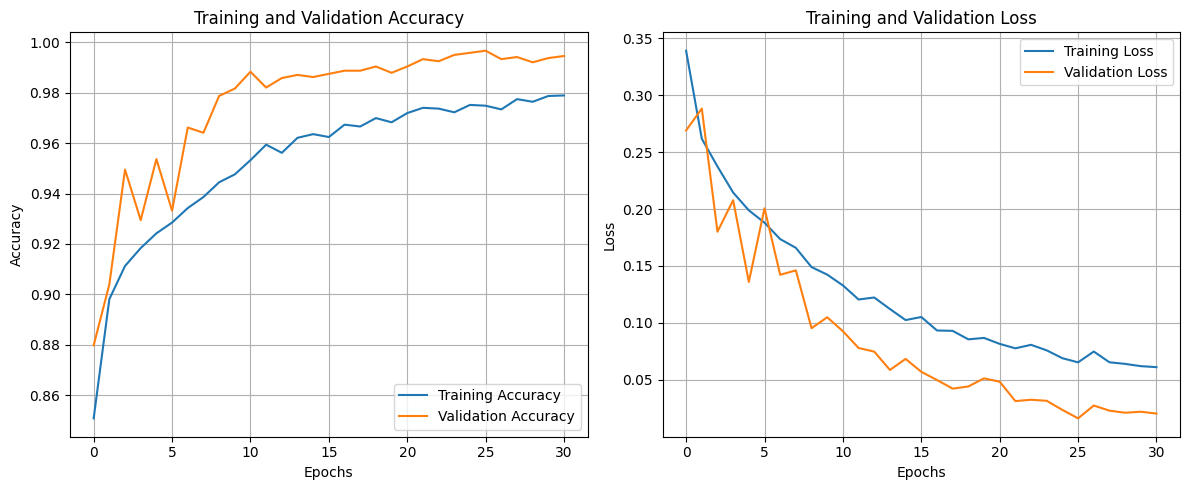

In [30]:

# Create a figure with two subplots for accuracy and loss
plt.figure(figsize=(12, 5))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Test Set Performance:

Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.98      0.98      1498
         1.0       0.91      0.90      0.90       277

    accuracy                           0.97      1775
   macro avg       0.94      0.94      0.94      1775
weighted avg       0.97      0.97      0.97      1775



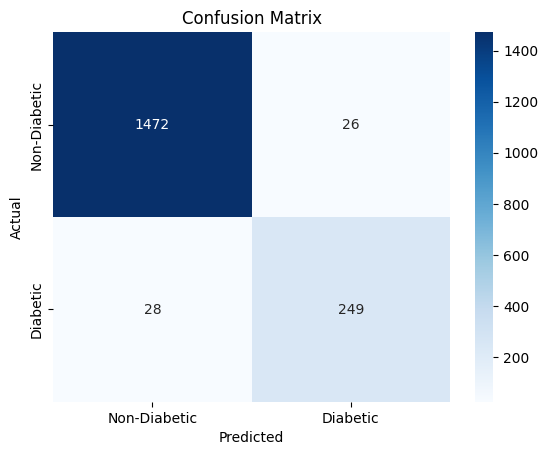

In [31]:
# Evaluate on the test set
y_test_pred_prob = best_model.predict(X_test)
y_test_pred = (y_test_pred_prob > 0.5).astype(int)

# Metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("Test Set Performance:")
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))

cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Diabetic', 'Diabetic'], yticklabels=['Non-Diabetic', 'Diabetic'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [64]:

# Neural Network ROC
nn_y_test_pred_prob = best_model.predict(X_test).ravel()  # Probabilities for positive class
nn_fpr, nn_tpr, _ = roc_curve(y_test, nn_y_test_pred_prob)
nn_auc = auc(nn_fpr, nn_tpr)

InvalidArgumentError: Graph execution error:

Detected at node sequential_4_1/dense_19_1/MatMul defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-64-5850ef5ea088>", line 2, in <cell line: 2>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 512, in predict

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 208, in one_step_on_data_distributed

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 198, in one_step_on_data

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 96, in predict_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py", line 901, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/models/sequential.py", line 212, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/models/functional.py", line 175, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/function.py", line 171, in _run_through_graph

  File "/usr/local/lib/python3.10/dist-packages/keras/src/models/functional.py", line 560, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py", line 901, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py", line 144, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/numpy.py", line 3445, in matmul

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/numpy.py", line 477, in matmul

Matrix size-incompatible: In[0]: [32,24], In[1]: [34,96]
	 [[{{node sequential_4_1/dense_19_1/MatMul}}]] [Op:__inference_one_step_on_data_distributed_525167]

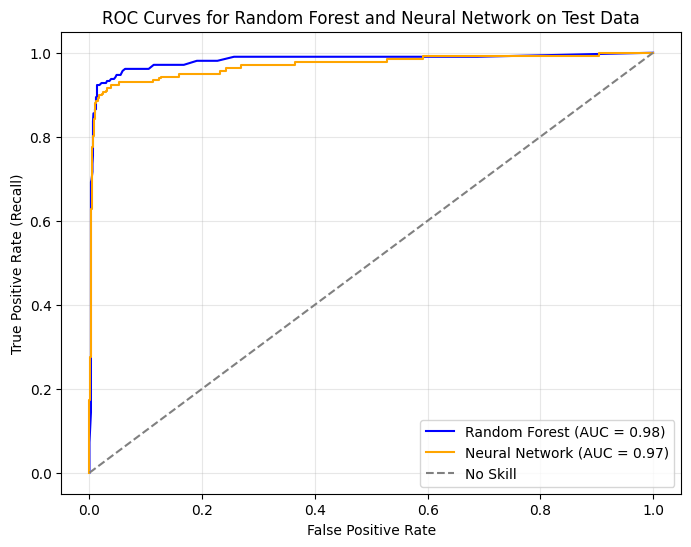

In [46]:
# Plot the ROC curves
plt.figure(figsize=(8, 6))
plt.plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC = {rf_auc:.2f})', color='blue')
plt.plot(nn_fpr, nn_tpr, label=f'Neural Network (AUC = {nn_auc:.2f})', color='orange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='No Skill')

plt.title('ROC Curves for Random Forest and Neural Network on Test Data')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()